In [1]:
# Imports all the required packages
import os
import argparse
import numpy as np
import os.path as osp
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.data import (InMemoryDataset, download_url, extract_zip,Data)

import torch
#from torcheval.metrics import R2Score # To be implemented
import torch.nn as nn
import torch.nn.functional as F
from rdkit.Chem import DataStructs
from torch_geometric.loader import DataLoader

import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit import rdBase
    from rdkit.Chem.rdchem import HybridizationType
    from rdkit import RDConfig
    from rdkit.Chem import ChemicalFeatures
    from rdkit.Chem.rdchem import BondType as BT
    from rdkit.Chem import Draw
    rdBase.DisableLog('rdApp.error')
except ImportError:
    rdkit = None

c:\Users\kanad\Desktop\Github repos\ME_793_PROJECT\793_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model definition used for regression

class GCNlayer(nn.Module):
    
    def __init__(self, n_features, conv_dim1, conv_dim2, conv_dim3, concat_dim, dropout):
        super(GCNlayer, self).__init__()
        self.n_features = n_features
        self.conv_dim1 = conv_dim1
        self.conv_dim2 = conv_dim2
        self.conv_dim3 = conv_dim3
        self.concat_dim =  concat_dim
        self.dropout = dropout   # Dropout Layer 
        
        self.conv1 = GCNConv(self.n_features, self.conv_dim1)
        self.bn1 = BatchNorm1d(self.conv_dim1)
        self.conv2 = GCNConv(self.conv_dim1, self.conv_dim2)
        self.bn2 = BatchNorm1d(self.conv_dim2)
        self.conv3 = GCNConv(self.conv_dim2, self.conv_dim3)
        self.bn3 = BatchNorm1d(self.conv_dim3)
        self.conv4 = GCNConv(self.conv_dim3, self.concat_dim)
        self.bn4 = BatchNorm1d(self.concat_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        
        # Global sum aggregrator function
        x = global_add_pool(x, data.batch) 
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
class FClayer(nn.Module):
    
    def __init__(self, concat_dim, pred_dim1, pred_dim2, out_dim, dropout):
        super(FClayer, self).__init__()
        self.concat_dim = concat_dim
        self.pred_dim1 = pred_dim1
        self.pred_dim2 = pred_dim2
        self.out_dim = out_dim
        self.dropout = dropout

        # Should I apply bias to the linear layer ?
        self.fc1 = Linear(self.concat_dim, self.pred_dim1,bias=True)
        self.bn1 = BatchNorm1d(self.pred_dim1)
        self.fc2 = Linear(self.pred_dim1, self.pred_dim2,bias=True)
        self.fc3 = Linear(self.pred_dim2, self.out_dim,bias=True) 
    
    def forward(self, data):
        x = F.relu(self.fc1(data))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc3(x)
        return x

# Model definition  
class GCN_Model_reg(nn.Module):
    def __init__(self, args):
        super(GCN_Model_reg, self).__init__()
        
        # Convolutional Layer call
        self.conv = GCNlayer(args.n_features,args.conv_dim1,args.conv_dim2,args.conv_dim3,args.concat_dim,args.dropout)

        # Fully connected layer call
        self.fc = FClayer(args.concat_dim,args.pred_dim1,args.pred_dim2,args.out_dim,args.dropout)
        
    def forward(self, data):
        x = self.conv(data) # Calling the convolutional layer
        x = self.fc(x) # Calling the Fully Connected Layer
        return x

In [3]:
# pytorch will be run on cpu
seed=100
paser = argparse.ArgumentParser()
args = paser.parse_args("")
np.random.seed(200)
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [731]:
# Inputs required by the program
args.epoch = 400
args.lr = 0.0001
args.optim = 'Adam'
args.step_size = 25
args.gamma = 0.8
args.dropout = 0.1
args.n_features = 29
dim = 512
args.conv_dim1 = 128
args.conv_dim2 = 512
args.conv_dim3 = 1024
args.concat_dim = 512
args.pred_dim1 = 128
args.pred_dim2 = 64
args.out_dim = 1

In [732]:
# encoding of all variables

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 
def get_intervals(l):
    """For list of lists, gets the cumulative products of the lengths"""
    intervals = len(l) * [0]
    # Initalize with 1
    intervals[0] = 1
    for k in range(1, len(l)):
        intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
    return intervals

def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        print("Add value to list of length {}".format(len(l)))
        return len(l)

In [733]:
# Atom features

possible_atom_list = ['H','C', 'O', 'F','N','Cl','P','S','Si','Br','I']  # Atomic symbol 11

aromatic=[0,1] # Aromatic 1
isring=[0,1]   # Ring 1
possible_numH_list = [0, 1, 2, 3, 4] # Total Number of bonded hydrogen atoms possible 5
num_bonds = [0, 1, 2, 3, 4, 5]  # Total Number of Hs a carbon can bond / Total number of bonds an atom make 6
possible_formal_charge_list = [-4,-3, -2, -1, 0, 1, 2, 3, 4]

# sp3d is removed because it doesnot vary according to the paper . Hybridization 4
possible_hybridization_list = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,Chem.rdchem.HybridizationType.SP3,Chem.rdchem.HybridizationType.SP3D2]

# storing all the features in a detailed list
reference_lists = [possible_atom_list, possible_numH_list,possible_formal_charge_list, num_bonds,aromatic,isring,possible_hybridization_list]

intervals = get_intervals(reference_lists)
print(intervals)

[1, 6, 60, 420, 1260, 3780, 18900]


- Total number of atom features used here is = 29

In [734]:
# Concatenate the entire feature list
def get_feature_list(atom):
    features = 5 * [0]
    features[0] = safe_index(possible_atom_list, atom.GetSymbol())
    features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
    features[2] = safe_index(num_bonds, atom.GetImplicitValence())
    features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())    
    features[4] = safe_index(possible_hybridization_list, atom.GetHybridization())
    return features

In [735]:
def features_to_id(features, intervals):
    """Convert list of features into index using spacings provided in intervals"""
    id = 0
    for k in range(len(intervals)):
        id += features[k] * intervals[k]
    id = id + 1
    return id

def id_to_features(id, intervals):
    features = 6 * [0]
    id -= 1
    for k in range(0, 6 - 1):
        features[6 - k - 1] = id // intervals[6 - k - 1]
        id -= features[6 - k - 1] * intervals[6 - k - 1]
    features[0] = id
    return features

def atom_to_id(atom):
    """Return a unique id corresponding to the atom type"""
    features = get_feature_list(atom)
    return features_to_id(features, intervals)


In [736]:
def atom_features(atom,bool_id_feat=False,explicit_H=False):
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        from rdkit import Chem
        results = np.array(one_of_k_encoding_unk(atom.GetSymbol(),possible_atom_list) + 
                           one_of_k_encoding_unk(atom.GetImplicitValence(), num_bonds) + 
                           [atom.GetFormalCharge()] + 
                           one_of_k_encoding_unk(atom.GetHybridization(), possible_hybridization_list) + 
                           [atom.GetIsAromatic()]+[atom.IsInRing()])
    if not explicit_H:
        results = np.array(results.tolist() + one_of_k_encoding_unk(atom.GetTotalNumHs(),possible_numH_list))  # include neighbouring Hs
    return np.array(results)

In [737]:
# Bond Features

def bond_features(bond):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                  bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                  bond.GetIsConjugated(),bond.IsInRing()]
    
    # Include stereo bond features as it effects the boiling point
    bond_feats = bond_feats + one_of_k_encoding_unk(str(bond.GetStereo()),["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)


In [738]:
# Create  atom pair of two connected molecules to pass messages

def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

# create a graph data structure comprising of x=node_f, edge_index = bond pair info, 
def mol2vec(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond) for bond in bonds]

    for bond in bonds:
        edge_attr.append(bond_features(bond))
        
    # Graph data to be used
    data = Data(x=torch.tensor(node_f, dtype=torch.float),edge_index=torch.tensor(edge_index, dtype=torch.long),edge_attr=torch.tensor(edge_attr,dtype=torch.float))
    
    return data

In [739]:
# Return mol info
def make_mol(df):
    mols = {}
    for i in range(df.shape[0]):
        mols[Chem.MolFromSmiles(df['Smiles'].iloc[i])] = df['Tb'].iloc[i]
    return mols

In [740]:
# Convert the dataset with X values and y values to be trained/tested
def make_vec(mols):
    X = [mol2vec(m) for m in mols.keys()]
    for i, data in enumerate(X):
        y = list(mols.values())[i]
        data.y = torch.tensor([y], dtype=torch.float)
    return X

In [741]:
# Importing Dataset
dataset = pd.read_csv('../data/raw_data.csv', low_memory=False)
dataset = pd.concat([dataset['Smiles'], dataset['Tb']], axis=1)
dataset

,Smiles,Tb
0,CCC(O)CCC(F)(F)F,413.80
1,CCC(CC)ON(=O)=O,413.15
2,Clc1ccc(Cl)c(c1)C(=O)O,574.15
3,NC(C)Cc1ccccc1,476.15
4,COc1ccc(cc1)NC(=O)C,608.15
...,...,...
5271,BrC(F)(F)Oc1ccc(cc1)C(C)(C)COCc2cccc(Oc3ccccc3)c2,564.15
5272,OCC(C)CC(F)(F)F,405.65
5273,Clc1ccc(cc1)CC2CCC(C)(C)C2(O)CN3C=NC=N3,558.15
5274,CCOC(=O)C(Cl)Cc1cc(c(F)cc1Cl)N2N=C(C)N(C(F)F)C2=O,625.65


In [742]:

# Standardize the Boiling Point values
mean=dataset['Tb'].mean()
std=dataset['Tb'].std()
dataset['Tb']=(dataset['Tb']-mean)/std
dataset.describe()
print(mean,std)


463.8188305534496 89.93284098607387


In [743]:
# Scale the dataset to values between 0 and 1

min_val=dataset['Tb'].min()
max_val=dataset['Tb'].max()
dataset['Tb']=(dataset['Tb']-min_val)/(max_val-min_val)
dataset.describe()
print(max_val,min_val)

23.03197749270811 -4.212018951031545


In [744]:
# Save Checkpoint for model evaluation :
def save_checkpoint(epoch, model, optimizer, filename):
    state = {'Epoch': epoch,'State_dict': model.state_dict(),'optimizer': optimizer.state_dict()}
    torch.save(state, filename)

In [745]:
# Train test split 
Train_set, Test_set = train_test_split(dataset, test_size=0.15, shuffle=True, random_state=seed)
Train_set = Train_set.reset_index(drop=True)
Test_set = Test_set.reset_index(drop=True)
Train_set

,Smiles,Tb
0,CCCCCCCCCCCCCCCCCC(=O)OCCOCCOCCOCCO,0.210654
1,O=C(Cl)c1ccccc1C(=O)Cl,0.191512
2,CCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCCCC...,0.331464
3,Clc1ccc(c(Cl)c1)c2cc(Cl)cc(Cl)c2,0.222694
4,CC=CC(C)C,0.100701
...,...,...
4479,CCCCc1cccc(O)c1,0.178003
4480,OCc1ccc(cc1)C(C)C,0.178411
4481,CC1=CC(=O)C(CC1)C(C)C,0.171881
4482,Clc1ccc(cc1)C(C(Cl)Cl)c2ccc(Cl)cc2,0.219633


In [746]:
train_mols = make_mol(Train_set)
test_mols = make_mol(Test_set)

train_X = make_vec(train_mols)
test_X = make_vec(test_mols)


In [747]:
# Model activation

model = GCN_Model_reg(args)
model = model.to(device)

In [748]:
train_loader = DataLoader(train_X, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=len(test_X), shuffle=False, drop_last=True)

In [749]:
def train(model, device, optimizer, train_loader, criterion, args):
    train_correct = 0
    train_total = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        targets = data.y.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        
        #print(outputs)
        #print(targets)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)

        correct_dim_output=outputs.squeeze() # done to reshape the outputs and match with targets
        loss = criterion(correct_dim_output, targets)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_train_loss /= len(train_loader)
    print('- Loss : %.4f' % epoch_train_loss)
    return model, epoch_train_loss

In [750]:
def experiment(model, train_loader, device, args):

    
    optimizer = optim.Adam(model.parameters(), lr=args.lr,weight_decay=0.001) # Add l2 regularizer ??
    criterion = nn.MSELoss() # decide on type of losses later
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
    
    list_train_loss = list()
    list_train_acc = list()
    print('[Train]')
    for epoch in range(args.epoch):
        
        print('- Epoch :', epoch+1)
        model, train_loss= train(model, device, optimizer, train_loader, criterion, args)
        scheduler.step()
        list_train_loss.append(train_loss)
    
    
    
     
    save_checkpoint(epoch, model, optimizer, 'model.pt')
    
    return args

In [751]:
result = vars(experiment(model, train_loader, device, args))

[Train]
- Epoch : 1
- Loss : 0.0163
- Epoch : 2
- Loss : 0.0070
- Epoch : 3


KeyboardInterrupt: 

In [ ]:
def test(model, device, test_loader, args):
    train_correct = 0
    train_total = 0
    epoch_train_loss = 0
    y_score=[]
    y_test=[]
    with torch.no_grad():
     for i, data in enumerate(test_loader):
        data = data.to(device)
        targets = data.y.to(device)
        outputs = model(data)
        #print(outputs)
        #print(targets)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)

        correct_dim_output=outputs.squeeze() # done to reshape the outputs and match with targets
        y_score.append(outputs.numpy())
        y_test.append(targets.numpy())
    
    return model, epoch_train_loss,y_score,y_test

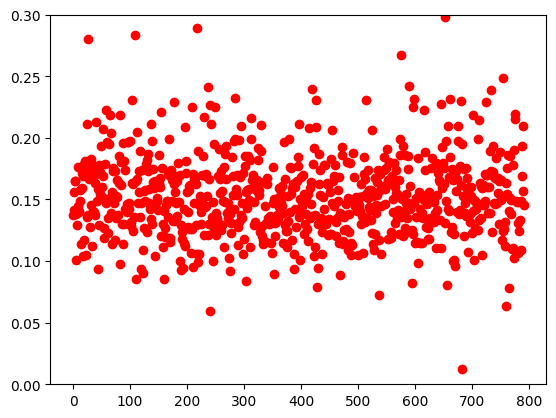

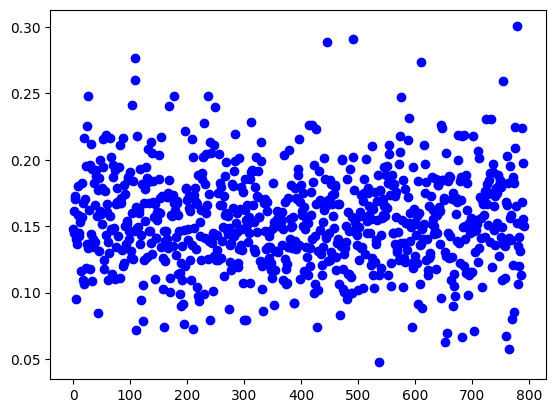

In [ ]:
import matplotlib.pyplot as plt
model, epoch_train_loss,y_score,y_test=test(model, device,test_loader, args)

# y_score is in the form of torch tensor. So not converted to numpy properly
x=[i for i in range(len(y_score)-1)]
#print(len(x),y_score[0])
#print(list(y_test[0]))
target=list(y_test[0])
predicted=[]
for i in range(len(y_score[0])):
    predicted.append(y_score[0][i][0])



plt.ylim(0,0.3)
plt.scatter(x=[i for i in range(len(predicted))],y=predicted,color='red',label='Predicted')
plt.show()
plt.scatter(x=[i for i in range(len(predicted))],y=target,color='blue',label='Actual Values')
plt.show()

In [ ]:
# converting data to actual boiling points
c=0
for i in target:
    target[c]=target[c]*(max_val-min_val)+min_val
    target[c]=target[c]*std+mean
    c=c+1

c=0
for i in predicted:
    predicted[c]=predicted[c]*(max_val-min_val)+min_val
    predicted[c]=predicted[c]*std+mean
    c=c+1


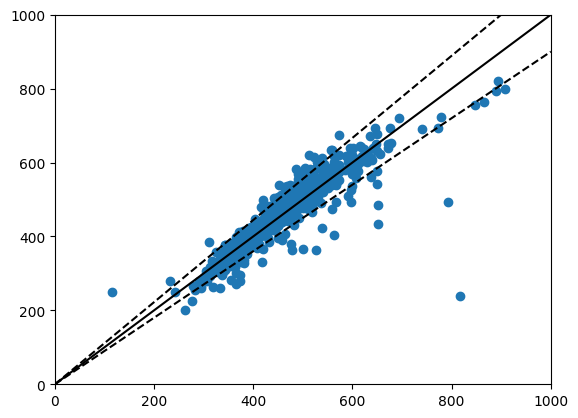

In [ ]:
plt.scatter(predicted,target)
plt.plot([0,1000],[0,1000],color='black')
plt.plot([0,900],[0,1000],color='black',linestyle='dashed') # +10 % error
plt.plot([0,1000],[0,900],color='black',linestyle='dashed') # -10 % error
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.show()

In [ ]:
# Save test 
test_data= pd.DataFrame()
test_data['GCN Actual Boiling Point']=target
test_data['GCN Predicted Boiling Point']=predicted
test_data.to_csv('../data/Results/GCN_Test_values.csv')


In [ ]:
# Train set predictions save
train_loader_pred = DataLoader(train_X, batch_size=len(train_X), shuffle=False, drop_last=True)

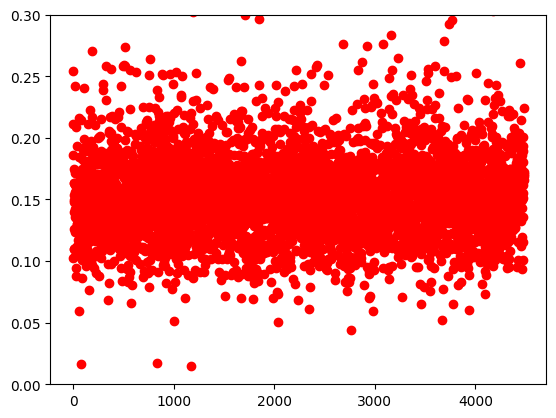

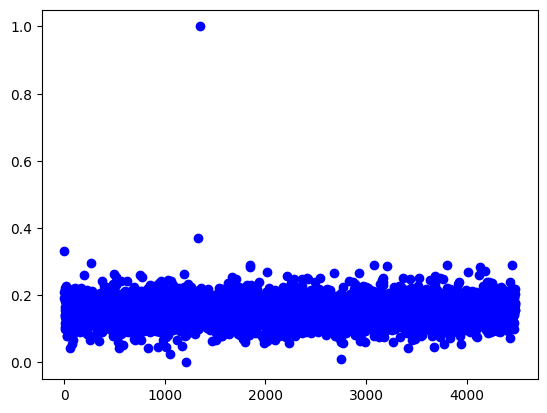

In [ ]:
import matplotlib.pyplot as plt
model, epoch_train_loss,y_score,y_test=test(model, device,train_loader_pred, args)

# y_score is in the form of torch tensor. So not converted to numpy properly
x=[i for i in range(len(y_score)-1)]
#print(len(x),y_score[0])
#print(list(y_test[0]))
target=list(y_test[0])
predicted=[]
for i in range(len(y_score[0])):
    predicted.append(y_score[0][i][0])



plt.ylim(0,0.3)
plt.scatter(x=[i for i in range(len(predicted))],y=predicted,color='red',label='Predicted')
plt.show()
plt.scatter(x=[i for i in range(len(predicted))],y=target,color='blue',label='Actual Values')
plt.show()

In [ ]:
# converting data to actual boiling points
c=0
for i in target:
    target[c]=target[c]*(max_val-min_val)+min_val
    target[c]=target[c]*std+mean
    c=c+1

c=0
for i in predicted:
    predicted[c]=predicted[c]*(max_val-min_val)+min_val
    predicted[c]=predicted[c]*std+mean
    c=c+1


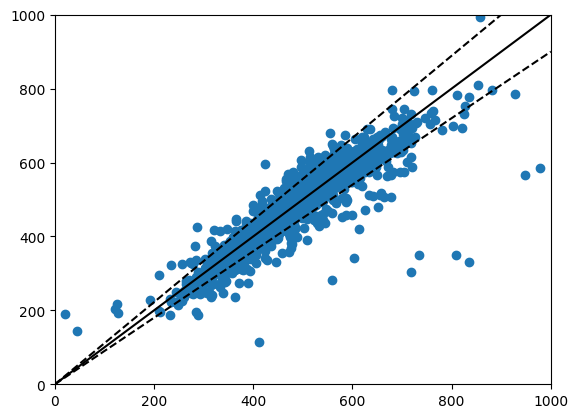

In [ ]:
plt.scatter(predicted,target)
plt.plot([0,1000],[0,1000],color='black')
plt.plot([0,900],[0,1000],color='black',linestyle='dashed') # +10 % error
plt.plot([0,1000],[0,900],color='black',linestyle='dashed') # -10 % error
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.show()

In [ ]:
# Save train
test_data= pd.DataFrame()
test_data['GCN Actual Boiling Point']=target
test_data['GCN Predicted Boiling Point']=predicted
test_data.to_csv('../data/Results/GCN_Train_values.csv')
